In [2]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

In [4]:
train = pd.read_csv('./data/train.csv')

In [3]:
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [4]:
train["selected_text"].fillna("No content", inplace = True)

In [5]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [6]:
temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

In [8]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [9]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))

In [10]:
data = np.array(data)

In [11]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [12]:
len(labels)

27481

In [13]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


In [17]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 40)           200000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 123       
Total params: 209,883
Trainable params: 209,883
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
645/645 [==============================] - 26s 36ms/step - loss: 0.7930 - accuracy: 0.6512 - val_loss: 0.7187 - val_accuracy: 0.6859

Epoch 00001: val_accuracy improved from -inf to 0.68593, saving model to best_model2.hdf5
Epoch 2/70
645/645 [==============================] - 22s 35ms/step - loss: 0.5734 - accuracy: 0.7718 - val_loss: 0.5405 - val_accuracy: 0.7865

In [18]:
best_model = keras.models.load_model("Sentiment_analysis_BiLSTM.hdf5")

In [19]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 3s - loss: 0.4256 - accuracy: 0.8478
Model accuracy:  0.8477659821510315


In [20]:
predictions = best_model.predict(X_test)

In [21]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

<Axes: >

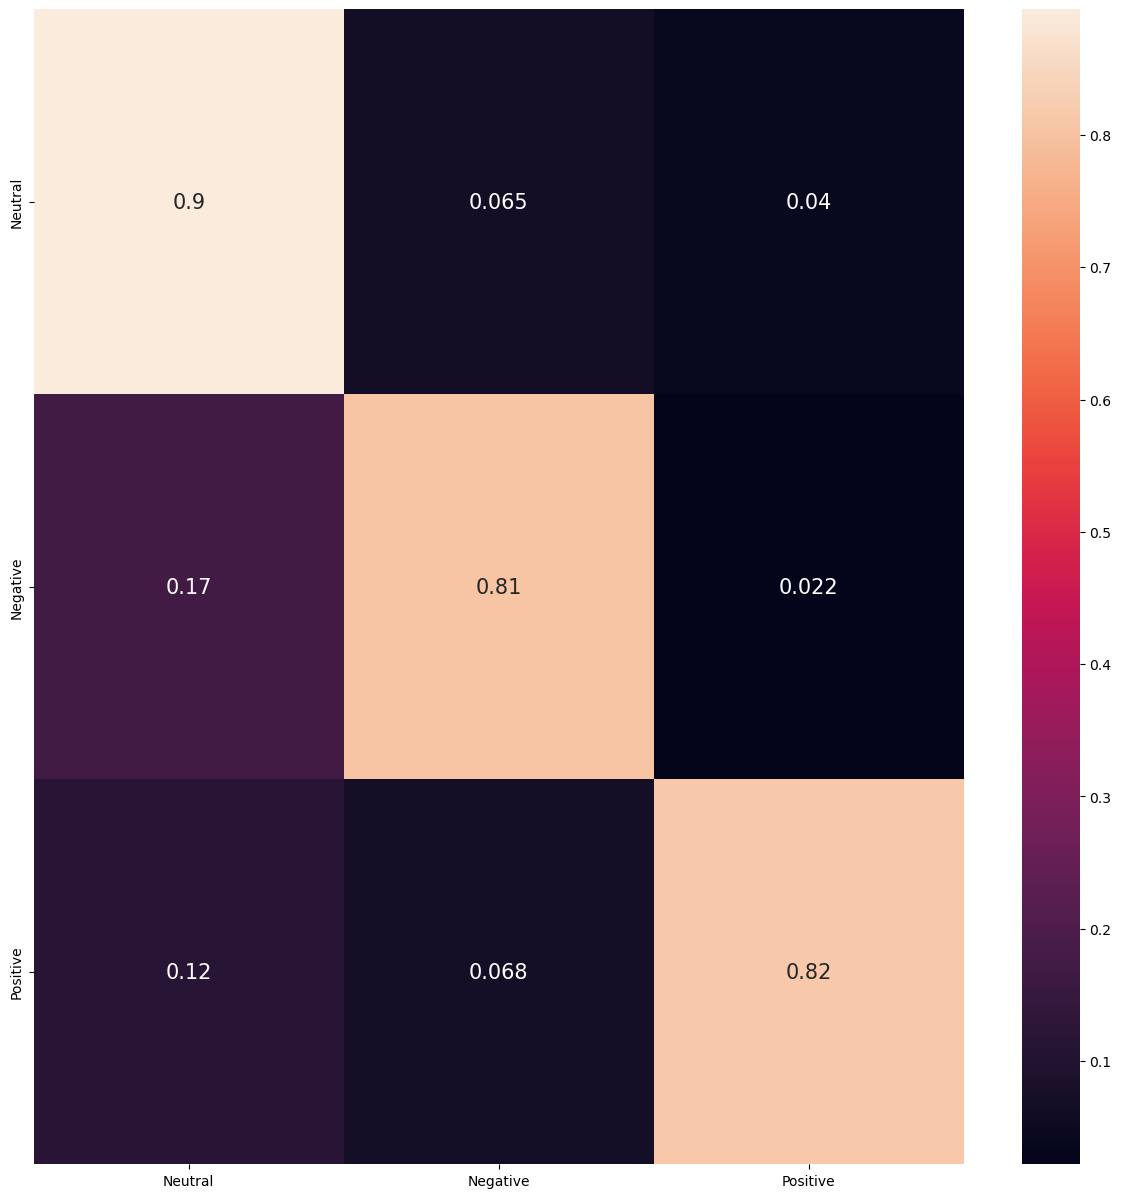

In [22]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [23]:
sentiment = ['Neutral','Negative','Positive']

In [24]:
sequence = tokenizer.texts_to_sequences(['It was bad'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [38]:
sequence = tokenizer.texts_to_sequences(['its nice'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'